In [193]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
import re

In [194]:
df = pd.read_csv('YoutubeCommentsDataSet.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [196]:
df.isna().sum()

Comment      44
Sentiment     0
dtype: int64

In [197]:
df = df.dropna()
df.isna().sum()

Comment      0
Sentiment    0
dtype: int64

In [198]:
sentiments = df['Sentiment'].value_counts()
sentiments

Sentiment
positive    11402
neutral      4625
negative     2337
Name: count, dtype: int64

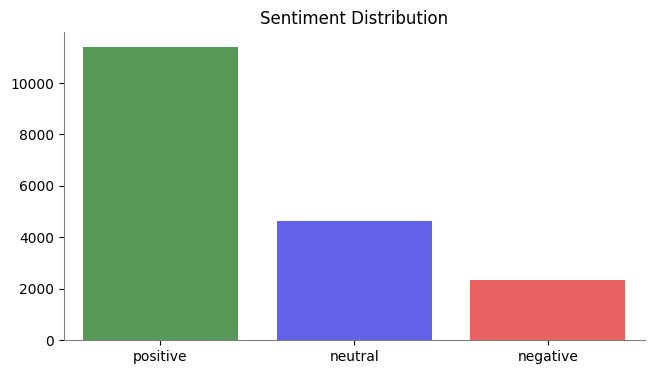

In [199]:
fig,ax = plt.subplots(figsize=(7.5,4))
ax = sns.barplot(x=sentiments.index,
    y=sentiments.values,
    hue=sentiments.index,
    palette=['green', 'blue', 'red'],
    alpha=0.7)

ax.set_title('Sentiment Distribution')
ax.set_xlabel('')
ax.set_ylabel('')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

# Remove the erroneous arrowprops line
plt.show()

In [200]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer('english')
        self.contractions_map = {
            "won't": "will not",
            "can't": "cannot",
            "n't": " not",
            "'re": " are",
            "'s": " is",
            "'d": " would",
            "'ll": " will",
            "'t": " not",
            "'ve": " have",
            "'m": " am"
        }
        self.contractions_pattern = re.compile('|'.join(map(re.escape, self.contractions_map.keys())))
    
    def expand_contractions(self, text):
        """Reemplaza contracciones en inglés con sus formas expandidas"""
        def replace(match):
            return self.contractions_map[match.group(0)]
        return self.contractions_pattern.sub(replace, text)
    
    def remove_stopwords(self, text):
        """Elimina stopwords del texto"""
        return ' '.join(word for word in text.split() if word not in self.stop_words)
    
    def apply_stemming(self, text):
        """Aplica stemming a cada palabra del texto"""
        return ' '.join(self.stemmer.stem(word) for word in text.split())
    
    def preprocess(self, text):
        """Pipeline completo de preprocesamiento"""
        if not isinstance(text, str) or not text.strip():
            return ""
            
        text = text.lower().strip()
        text = self.expand_contractions(text)
        text = self.remove_stopwords(text)
        text = self.apply_stemming(text)
        return text

preprocessor = TextPreprocessor()

In [201]:
df['Comment'] = df['Comment'].apply(preprocessor.preprocess)
df.head()

,Comment,Sentiment
0,let forget appl pay 2014 requir brand new ipho...,neutral
1,nz 50 retail don't even contactless credit car...,negative
2,forev acknowledg channel help lesson idea expl...,positive
3,whenev go place doesn't take appl pay doesn't ...,negative
4,appl pay conveni secur easi use use korean jap...,positive


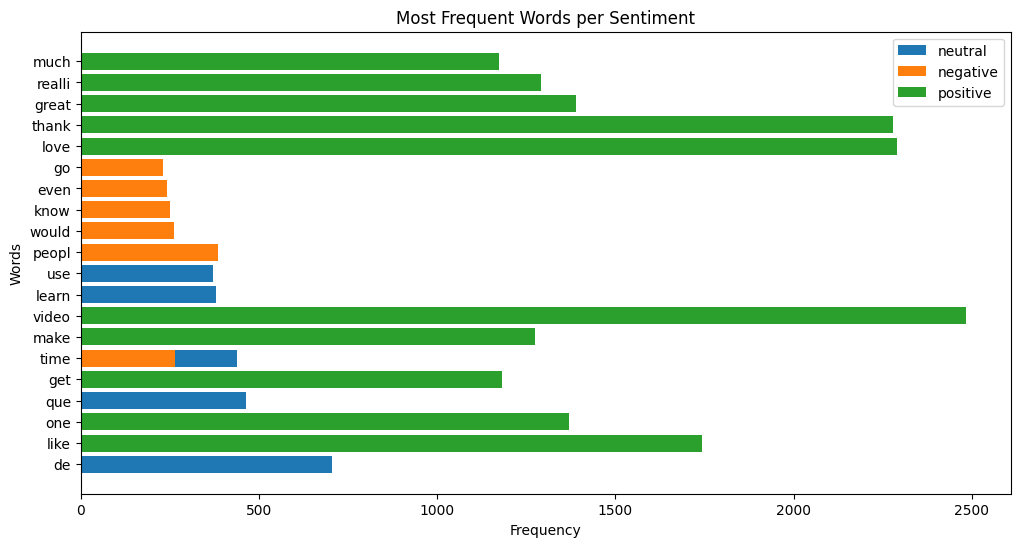

In [202]:
from collections import Counter

plt.figure(figsize=(12, 6))
for sentiment in df["Sentiment"].unique():
    words = " ".join(df[df["Sentiment"] == sentiment]["Comment"])
    most_common = Counter(words.split()).most_common(10)
    words, counts = zip(*most_common)
    
    plt.barh(words, counts, label=sentiment)

plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Most Frequent Words per Sentiment")
plt.show()

In [203]:
label = LabelEncoder()
df['Sentiment'] = label.fit_transform(df['Sentiment'])
X = df['Comment']
y = df['Sentiment']

In [204]:
# vectorizer = CountVectorizer()
# X_vectorizer = vectorizer.fit_transform(X)
# tokens = vectorizer.get_feature_names_out()
# X_vectorizer_df = pd.DataFrame(X_vectorizer.toarray(), columns=tokens)
# X_vectorizer_df.head()

In [205]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)
tokens_tfidf = tfidf.get_feature_names_out()
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tokens_tfidf)
X_tfidf_df.head()

,000,0000,0001,0018,01,10,100,1000,10000,100k,...,من,और,कर,नह,हम,ấy,スクラッチング,タッピング,ラップ,너무
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
x_train, x_test, y_train, y_test = train_test_split(X_tfidf_df, y, test_size=0.2, random_state=42,stratify=y)

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

In [208]:
def plot_model_performance(y_true, y_pred, classes, figsize=(15, 6)):
    """
    Parámetros:
    - y_true: Valores reales
    - y_pred: Predicciones del modelo
    - classes: Lista con nombres de las clases
    - figsize: Tamaño de la figura general
    """
    plt.figure(figsize=figsize)
    
    # Subplot 1: Matriz de confusión
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix',fontfamily='serif',fontsize=14, fontweight='bold')
    
    # Subplot 2: Classification report
    plt.subplot(1, 2, 2)
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df = pd.DataFrame(report).transpose().round(2)
    
    # Ocultar ejes para el reporte
    ax = plt.gca()
    ax.axis('off')
    ax.axis('tight')
    
    # Crear tabla
    table = ax.table(cellText=df.values,
                    colLabels=df.columns,
                    rowLabels=df.index,
                    cellLoc='center',
                    loc='center')
    
    # Formatear tabla
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    
    # Resaltar filas de clases
    for i, key in enumerate(df.index):
        if key in classes:
            for j in range(len(df.columns)):
                table[(i+1, j)].set_facecolor('#F5F5F5')
    
    plt.title('Classification Report',fontfamily='serif',fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

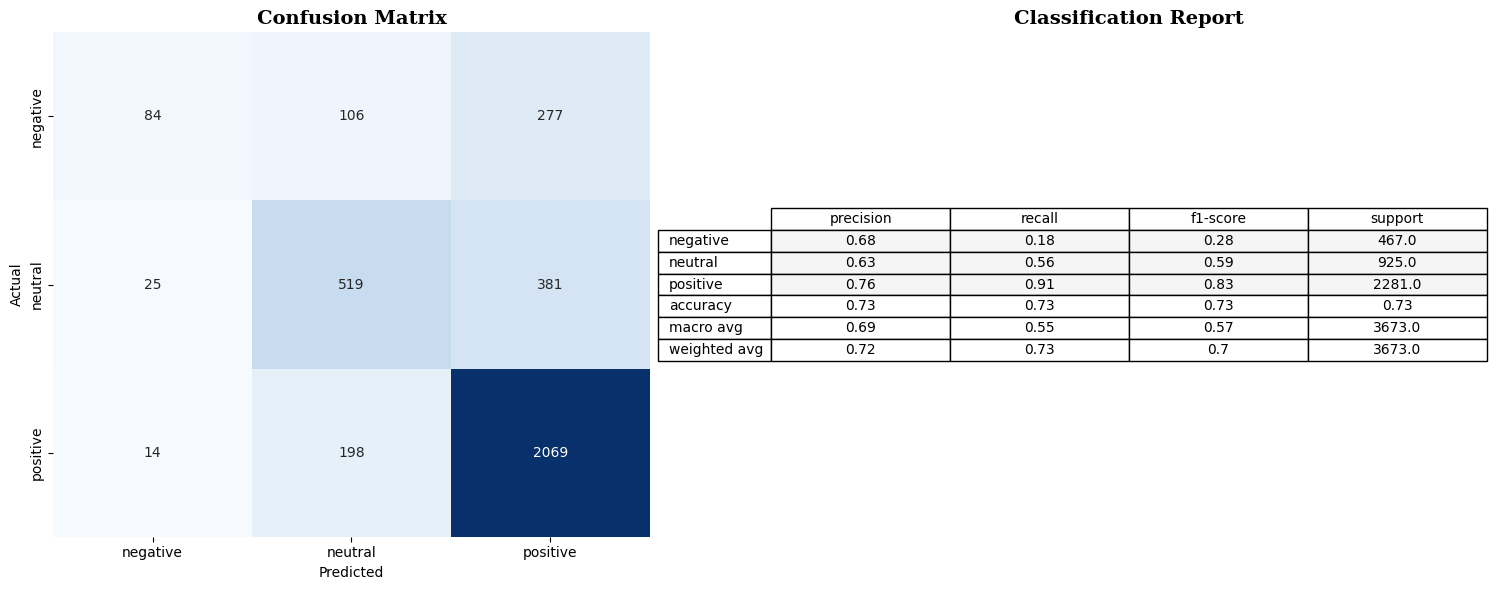

In [209]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
plot_model_performance(y_test, y_pred, ['negative', 'neutral', 'positive'])

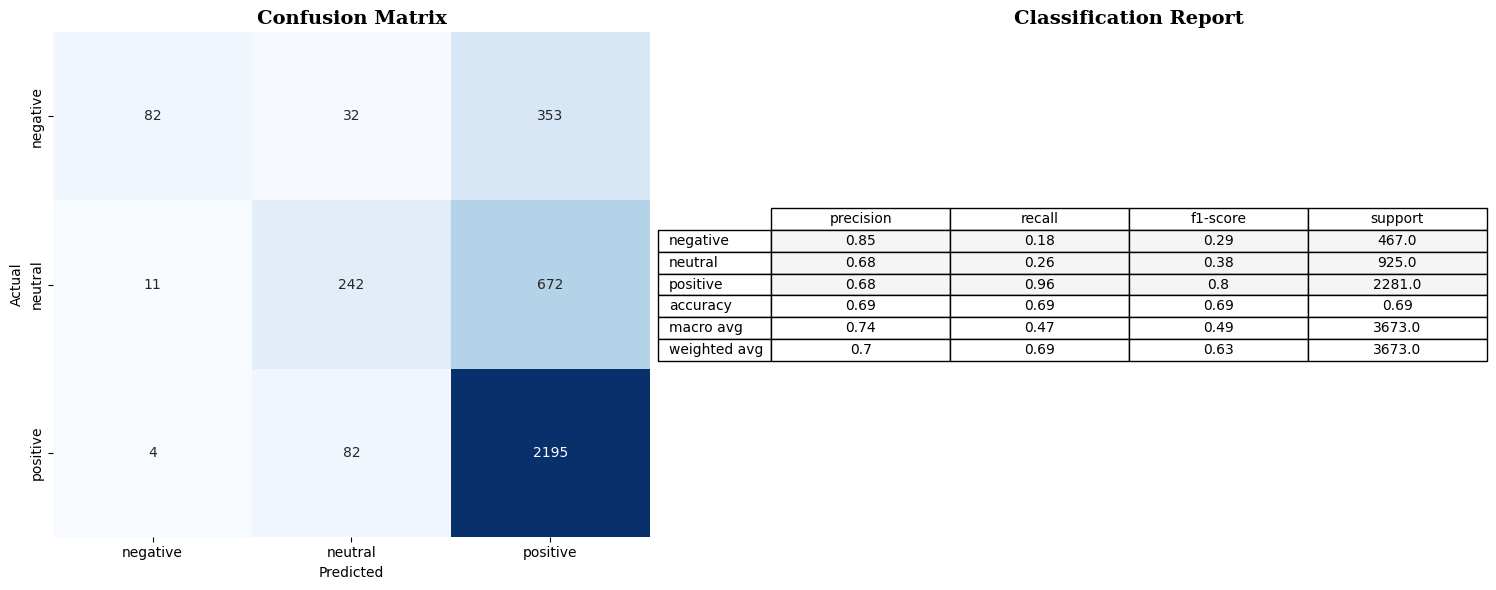

In [210]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
plot_model_performance(y_test, y_pred, ['negative', 'neutral', 'positive'])

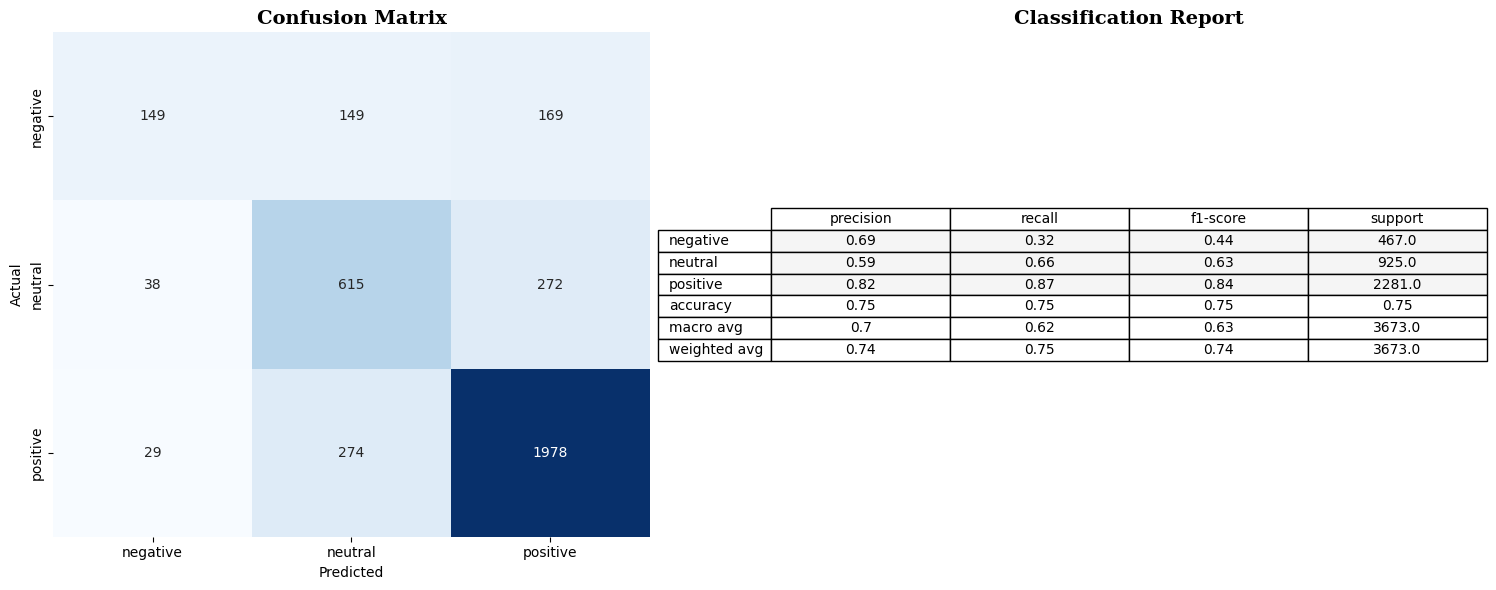

In [211]:
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
plot_model_performance(y_test, y_pred, ['negative', 'neutral', 'positive'])